In [36]:
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import os
import math
import random

In [3]:
def find_matching_keypoints(image1, image2):
    #Input: two images (numpy arrays)
    #Output: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    sift = cv2.SIFT_create()
    kp1, desc1 = sift.detectAndCompute(image1, None)
    kp2, desc2 = sift.detectAndCompute(image2, None)

    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(desc1, desc2, k=2)

    good = []
    pts1 = []
    pts2 = []
    for i, (m, n) in enumerate(matches):
        if m.distance < 0.8 * n.distance:
            good.append(m)
            pts2.append(kp2[m.trainIdx].pt)
            pts1.append(kp1[m.queryIdx].pt)

    pts1 = np.int32(pts1)
    pts2 = np.int32(pts2)
    return pts1, pts2


In [4]:
def drawlines(img1,img2,lines,pts1,pts2):
    #img1: image on which we draw the epilines for the points in img2
    #lines: corresponding epilines
    r,c = img1.shape
    img1 = cv2.cvtColor(img1,cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2,cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines,pts1,pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ]) 
        img1 = cv2.line(img1, (x0,y0), (x1,y1), color,1)
        img1 = cv2.circle(img1,tuple(pt1),5,color,-1)
        img2 = cv2.circle(img2,tuple(pt2),5,color,-1)
    return img1,img2

In [80]:
def normalisePoints(pts1, pts2):
    centroid_pts1 = ( np.mean(pts1[:, 0]), np.mean(pts1[:, 1]) )
    centroid_pts2 = ( np.mean(pts2[:, 0]), np.mean(pts2[:, 1]) )

    distance_pts1 = 0
    distance_pts2 = 0
    for i,j in zip(pts1, pts2):
        distance_pts1 = distance_pts1 + ((i[0]-centroid_pts1[0])**2 + (i[1]-centroid_pts1[1])**2)**0.5
        distance_pts2 = distance_pts2 + ((j[0]-centroid_pts2[0])**2 + (j[1]-centroid_pts2[1])**2)**0.5

    s1 = (distance_pts1/len(pts1))/(math.sqrt(2))
    s2 = (distance_pts2/len(pts2))/(math.sqrt(2))
    
    Transformation_matrix_pts1 = np.array( [ [1/s1, 0, (-1/s1)*centroid_pts1[0]], [0, 1/s1, (-1/s1)*centroid_pts1[1]], [0, 0, 1] ] )
    Transformation_matrix_pts2 = np.array( [ [1/s2, 0, (-1/s2)*centroid_pts2[0]], [0, 1/s2, (-1/s2)*centroid_pts2[1]], [0, 0, 1] ] )
    
    normalised_pts1 = []
    normalised_pts2 = []
    for i,j in zip(pts1, pts2):
        normalised_pts1.append( Transformation_matrix_pts1  @ np.append(i, 1) )
        normalised_pts2.append( Transformation_matrix_pts2  @ np.append(j, 1) )
    
    return normalised_pts1, normalised_pts2, Transformation_matrix_pts1, Transformation_matrix_pts2

def FindFundamentalMatrix(pts1, pts2):
    #Input: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    #Output: fundamental matrix (numpy array of shape (3, 3))
    #todo: Normalize the points
    normalised_pts1, normalised_pts2, Transformation_matrix_pts1, Transformation_matrix_pts2 = normalisePoints(pts1, pts2)
    
    #todo: Form the matrix A
    matrix_A = []
    #ind = 0
    for i,j in zip(normalised_pts1,normalised_pts2):
        matrix_A.append( [i[0]*j[0], i[1]*j[0], j[0], i[0]*j[1], i[1]*j[1], j[1], i[0], i[1], 1] )
        #ind= ind+1
        #if ind==8:
        #    break

    matrix_A = np.array(matrix_A)
    #print(matrix_A)
    #todo: Find the fundamental matrix
    u, s, vh = np.linalg.svd(matrix_A, full_matrices=False)
    vh = np.transpose(vh)
    fundamental_matrix = np.reshape(vh[:,vh.shape[1]-1], (-1,3))
    u, s, vh = np.linalg.svd(fundamental_matrix, full_matrices=False)
    s[2] = 0
    s = np.diag(s)
    fundamental_matrix = u @ s @ vh 
    fundamental_matrix = Transformation_matrix_pts2.T @ fundamental_matrix @ Transformation_matrix_pts1
    
    return fundamental_matrix

def FindFundamentalMatrixRansac(pts1, pts2, num_trials = 1000, threshold = 0.01):
    #Input: two lists of corresponding keypoints (numpy arrays of shape (N, 2))
    #Output: fundamental matrix (numpy array of shape (3, 3))
    
    #todo: Run RANSAC and find the best fundamental matrix
    inlier_indices_count = 0 
    for iteration in range(num_trials):
        
        sample_indices = random.sample( range(len(pts1)), 8)
        sample_pts1 = np.take(pts1, sample_indices, axis=0)
        sample_pts2 = np.take(pts2, sample_indices, axis=0)
        #print( len(sample_pts1) )
        fundamental_matrix = FindFundamentalMatrix(sample_pts1, sample_pts2)
        
        matrix_A = []
        ind =0
        for i,j in zip(pts1,pts2):
            if ind not in sample_indices:
                matrix_A.append( [i[0]*j[0], i[1]*j[0], j[0], i[0]*j[1], i[1]*j[1], j[1], i[0], i[1], 1] )
            ind = ind + 1

        matrix_A = np.array(matrix_A)
        #print( len(matrix_A) )
        cost_fun_matrix = np.abs( matrix_A @ fundamental_matrix.flatten() )
        
        inlier_indices = np.sum(cost_fun_matrix < threshold)
        if iteration == 0:
            best_fundamental_matrix = fundamental_matrix
            
        if inlier_indices>inlier_indices_count:
            best_fundamental_matrix = fundamental_matrix
            #inlier_pts1 = np.take(pts1, inlier_indices, axis=0)
            #inlier_pts2 = np.take(pts2, inlier_indices, axis=0)
            #print(inlier_indices_count)
            inlier_indices_count = inlier_indices
        
    return best_fundamental_matrix


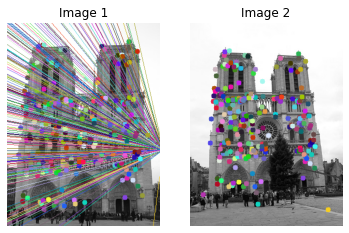

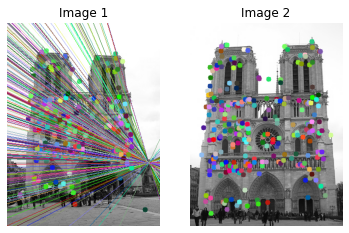

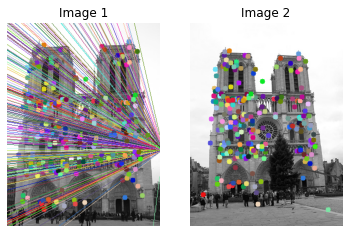

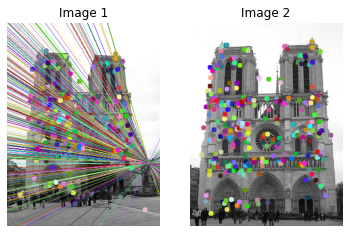

In [89]:
data_path = './data'
use_ransac = False

#Load images
image1_path = os.path.join(data_path, 'notredam_1.jpg')
image2_path = os.path.join(data_path, 'notredam2.jpg')
image1 = np.array(Image.open(image1_path).convert('L'))
image2 = np.array(Image.open(image2_path).convert('L'))


#Find matching keypoints
pts1, pts2 = find_matching_keypoints(image1, image2)
#print(pts1)
#print(pts2)
#Builtin opencv function for comparison
F_true = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)[0]

#todo: FindFundamentalMatrix
if use_ransac:
    F = FindFundamentalMatrixRansac(pts1, pts2)
else:
    F = FindFundamentalMatrix(pts1, pts2)
    F = F/F[2][2]

# Find epilines corresponding to points in second image,  and draw the lines on first image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F_true)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F_true)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()

# Find epilines corresponding to points in second image,  and draw the lines on first image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()






In [90]:
F

array([[ 1.23624920e-04,  5.17452634e-04, -1.71566331e-01],
       [-5.17174300e-04, -2.55120430e-05,  1.68976967e-01],
       [ 1.10466108e-01, -1.39148680e-01,  1.00000000e+00]])

In [91]:
F_true

array([[ 1.23624920e-04,  5.17452634e-04, -1.71566331e-01],
       [-5.17174300e-04, -2.55120430e-05,  1.68976967e-01],
       [ 1.10466108e-01, -1.39148680e-01,  1.00000000e+00]])

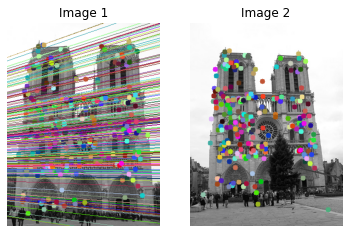

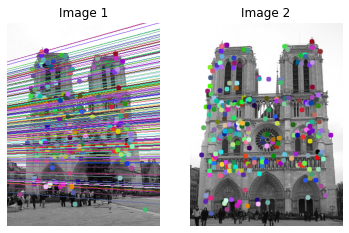

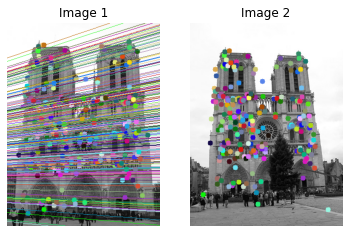

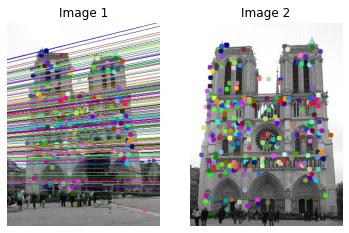

In [92]:
use_ransac = True
F_true = cv2.findFundamentalMat(pts1, pts2, cv2.RANSAC)[0]

#todo: FindFundamentalMatrix
if use_ransac:
    F = FindFundamentalMatrixRansac(pts1, pts2)
    F = F/F[2][2]
else:
    F = FindFundamentalMatrix(pts1, pts2)

# Find epilines corresponding to points in second image,  and draw the lines on first image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F_true)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F_true)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()

# Find epilines corresponding to points in second image,  and draw the lines on first image
lines1 = cv2.computeCorrespondEpilines(pts2.reshape(-1, 1, 2), 2, F)
lines1 = lines1.reshape(-1, 3)
img1, img2 = drawlines(image1, image2, lines1, pts1, pts2)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


# Find epilines corresponding to points in first image, and draw the lines on second image
lines2 = cv2.computeCorrespondEpilines(pts1.reshape(-1, 1, 2), 1, F)
lines2 = lines2.reshape(-1, 3)
img1, img2 = drawlines(image2, image1, lines2, pts2, pts1)
fig, axis = plt.subplots(1, 2)

axis[0].imshow(img1)
axis[0].set_title('Image 1')
axis[0].axis('off')
axis[1].imshow(img2)
axis[1].set_title('Image 2')
axis[1].axis('off')

plt.show()


In [93]:
F_true

array([[-1.49615824e-06,  5.28131010e-05, -1.65571622e-02],
       [-7.07202447e-05,  3.73674677e-06, -4.52668415e-02],
       [ 1.89973525e-02,  3.67221691e-02,  1.00000000e+00]])

In [94]:
F

array([[-1.54164797e-06,  5.21743456e-05, -1.78413487e-02],
       [-7.80821208e-05,  3.61494885e-06, -5.78360768e-02],
       [ 2.25916840e-02,  4.80443712e-02,  1.00000000e+00]])